In [1]:
import numpy as np
import pickle
from LoadInstancesExperiments import get_instance
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
cmap = plt.get_cmap('viridis')

In [2]:
# Directorio de datos generales
path = "../GeoData/"
out_time_test = "Results/LoadInstancesTime.txt"
data = ['t_total', 't_rutas_cuda', 't_rutas_nx', 't_info', 'bby_colapsos', 'bby_traffic']

In [3]:
if False:
    print('instancia\t\tp\t\t' + '\t\t'.join(data))
    res_instances = dict([i, []] for i in range(10))

    for i in range (10):
        for j in range (15):
            _, r = get_instance(path, str(i))
            linea = f'{i}\t\t{j}\t\t'

            for k in data:
                linea += f'{r[k]}\t\t'
                
            linea += '\n'
            print(linea, end="")
            
            res_instances[i].append(r)
            
            with open(out_time_test, 'a') as file:
                file.write(linea)
                
    with open('Results/TestingTimeCuda.pkl', 'wb') as f:  
        pickle.dump(res_instances, f)
        f.close()

In [4]:
with open('Results/TestingTimeCuda.pkl', 'rb') as f:
    res_instances = pickle.load(f) 
    f.close()

num_instancias = len(res_instances.values())

In [5]:
tot_bases = 1846
origenes = []
descartadas = []
destinos = []
victimas = []
min_demanda = []
max_demanda = []
min_victimas = []
max_victimas = []

for i in range(10):
    instance_number = i
    colapsos = gpd.read_file('../GeoData/Points_instances.gpkg', layer = 'Instance_' + str(instance_number))
    path = '../GeoData/Instances/Instance_' + str(instance_number) + '.pkl'
    
    with open(path, 'rb') as f:
            instance = pickle.load(f) 
            f.close()
        
    origenes.append(len(instance['origenes']))
    descartadas.append(tot_bases - len(instance['origenes']))
    destinos.append(len(instance['destinos']))
    victimas.append(colapsos['victimas'].sum())
    min_victimas = np.min(colapsos['victimas'])
    max_victimas = np.max(colapsos['victimas'])
    min_demanda.append(np.min(instance['demanda']))
    max_demanda.append(np.max(instance['demanda']))
    


# Crear el DataFrame de Pandas
data = {'Instancia': [i for i in range(num_instancias)],
        'Bases descartadas': descartadas,
        '$|I|$': origenes,
        '$|j|$': destinos,
        'Victimas': victimas,
        'Min. victimas': min_victimas,
        'Max. victimas': max_victimas,
        'Min. demanda': min_demanda,
        'Max. demanda': max_demanda,}
df = pd.DataFrame(data)

print('Datos generales de las instancias')

# Mostrar el DataFrame
df.head(10)

Datos generales de las instancias


,Instancia,Bases descartadas,$|I|$,$|j|$,Victimas,Min. victimas,Max. victimas,Min. demanda,Max. demanda
0,0,319,1527,43,334,2,45,2,26
1,1,482,1364,45,463,2,45,2,19
2,2,265,1581,44,381,2,45,3,17
3,3,227,1619,38,515,2,45,2,67
4,4,240,1606,19,193,2,45,5,44
5,5,235,1611,53,570,2,45,2,16
6,6,306,1540,23,192,2,45,5,29
7,7,267,1579,37,275,2,45,3,16
8,8,280,1566,35,376,2,45,3,28
9,9,139,1707,26,302,2,45,2,34


In [6]:
tiempos_totales = [ [ej['t_total'] for ej in instance] for instance in res_instances.values()]
tiempos_cuda = [ [ej['t_rutas_cuda'] for ej in instance] for instance in res_instances.values()]
tiempos_nx = [ [ej['t_rutas_nx'] for ej in instance] for instance in res_instances.values()]
tiempos_info = [ [ej['t_info'] for ej in instance] for instance in res_instances.values()]
tiempos_procesos = [np.array(tiempos_totales[i]) - np.array(tiempos_cuda[i]) - np.array(tiempos_info[i]) for i in range(num_instancias)]

promedio_total = [np.mean(i) for i in tiempos_totales]
promedio_cuda = [np.mean(i) for i in tiempos_cuda]
promedio_nx = [np.mean(i) for i in tiempos_nx]
promedio_info = [np.mean(i) for i in tiempos_info]
promedio_procesos = [np.mean(i) for i in tiempos_procesos]


min_cuda = [np.min(i) for i in tiempos_cuda]
min_nx = [np.min(i) for i in tiempos_nx]
min_info = [np.min(i) for i in tiempos_info]
min_procesos = [np.min(i) for i in tiempos_procesos]

max_cuda = [np.max(i) for i in tiempos_cuda]
max_nx = [np.max(i) for i in tiempos_nx]
max_info = [np.max(i) for i in tiempos_info]
max_procesos = [np.max(i) for i in tiempos_procesos]

std_cuda = [np.std(i) for i in tiempos_cuda]
std_nx = [np.std(i) for i in tiempos_nx]
std_info = [np.std(i) for i in tiempos_info]
std_procesos = [np.std(i) for i in tiempos_procesos]

data_rutas = {
    'Instancia': [i for i in range(num_instancias)],
    '$|I|$': origenes,
    '$|J|$': destinos,
    'i_mean': promedio_info,
    'i_std': std_info,
    'p_mean': promedio_procesos,
    'p_std': std_procesos,
    'c_mean': promedio_cuda,
    'c_std': std_cuda,
}
# Crear un DataFrame de pandas a partir del diccionario
df_rutas = pd.DataFrame(data_rutas)

df_rutas = df_rutas.apply(lambda x: x.round(3) if x.dtype == 'float' else x)

df_rutas.head(10)

,Instancia,$|I|$,$|J|$,i_mean,i_std,p_mean,p_std,c_mean,c_std
0,0,1527,43,23.935,1.039,32.511,1.689,30.361,1.461
1,1,1364,45,24.452,1.208,32.973,1.449,30.775,1.199
2,2,1581,44,24.225,0.988,32.070,1.204,26.961,0.965
3,3,1619,38,23.358,0.235,31.373,0.569,22.408,0.137
4,4,1606,19,23.268,0.235,31.126,0.288,10.737,0.040
5,5,1611,53,22.983,0.178,30.961,0.361,30.305,0.165
6,6,1540,23,23.120,0.185,30.616,0.430,14.456,0.075
7,7,1579,37,22.946,0.200,30.621,0.434,22.071,0.110
8,8,1566,35,22.880,0.134,30.754,0.454,21.503,0.072
9,9,1707,26,22.869,0.182,30.295,0.438,14.182,0.053


In [7]:
df_rutas['i_mean'].dtype == 'float'

True

In [8]:
dest_ord = sorted([(i,d) for i,d in enumerate(destinos)], key = lambda x: x[1])
print(dest_ord)
for i in range(10):
    print(str())

[(4, 19), (6, 23), (9, 26), (8, 35), (7, 37), (3, 38), (0, 43), (2, 44), (1, 45), (5, 53)]












## Comparativa de cuda y networkX

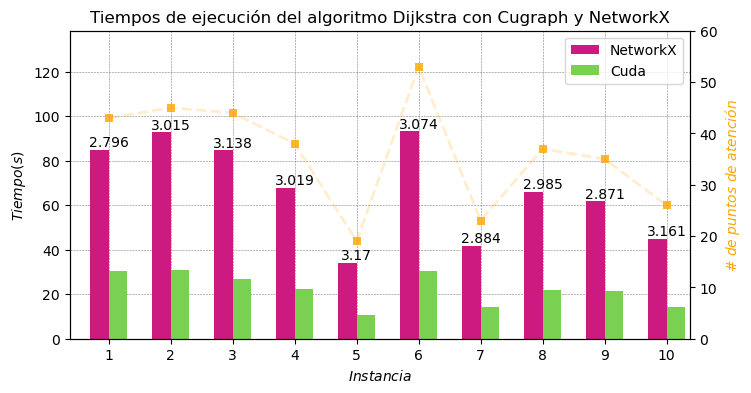

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))

# Coordenadas x para las barras
ind = np.arange(num_instancias)  # Posiciones en el eje x

# Ancho de las barras
ancho_barra = 1.2
esp = -0.1 # Espacio entre barras

# Crear el boxplot para cada sublista de tiempos
for i, tiempo_nx, tiempo_cuda in zip(range(len(tiempos_cuda)), tiempos_nx, tiempos_cuda):
    # ax.boxplot([tiempo_nx, tiempo_cuda], positions=[i*2 + i*2 + esp, i*2 + i*2+1 - esp], 
    #            widths=ancho_barra, showfliers=False, zorder = 3, medianprops=dict(color=(0,0,0,1)))
    ax.text(i*2 + i*2 + 0.5, np.mean(tiempo_nx) + 0.1, f'{np.round(np.mean(tiempo_nx)/np.mean(tiempo_cuda), 3)}', color='black', ha='center', va='bottom', zorder = 4)


# Dibujar las barras
rects1 = ax.bar(ind*2 + ind*2 + esp, [np.mean(i) for i in tiempos_nx], ancho_barra, label='NetworkX', color=(0.8,0.1,0.5,1), zorder = 2)
rects2 = ax.bar(ind*2 + ind*2 + 1 - esp, [np.mean(i) for i in tiempos_cuda], ancho_barra, label='Cuda', color=cmap(0.8), zorder = 2)


# Crear un segundo conjunto de ejes para el eje y derecho
ax2 = ax.twinx()

# Graficar los datos en el eje y derecho
ax2.plot(ind*2 + ind*2 +.5 , destinos, '--', color='orange',zorder=0, alpha = 0.2, lw=2)  
ax2.scatter(ind*2 + ind*2 +.5, destinos, color='orange', marker='s', zorder = 0, alpha = 0.8, linewidths=0)

# Configuración del eje y derecho
ax2.set_ylabel('# $de\ puntos\ de\ atención$', color='orange') 
ax2.set_ylim([0, 60])





# Configuración de ejes y etiquetas
ax.set_xlabel('$Instancia$')
ax.set_ylabel('$Tiempo (s)$')
ax.set_title('Tiempos de ejecución del algoritmo Dijkstra con Cugraph y NetworkX')
ax.set_xticks([i*2 + 2 * i + 0.5 for i in range(len(tiempos_nx))])
ax.set_xticklabels([f'{i+1}' for i in range(len(tiempos_nx))])
ax.set_xlim([-2, 2*(num_instancias-1) + 2*(num_instancias-1) +2])
ax.set_ylim([0, 1.5*np.max(tiempos_totales)])

# Leyenda para identificar los modelos
ax.legend()
ax.grid(True,zorder=0, color='gray', linestyle='--', linewidth=0.4)
# Mostrar la gráfica
fig.savefig('/home/cic/Tesis/Figuras/Results/tiemposCudaNx.png', dpi=300)

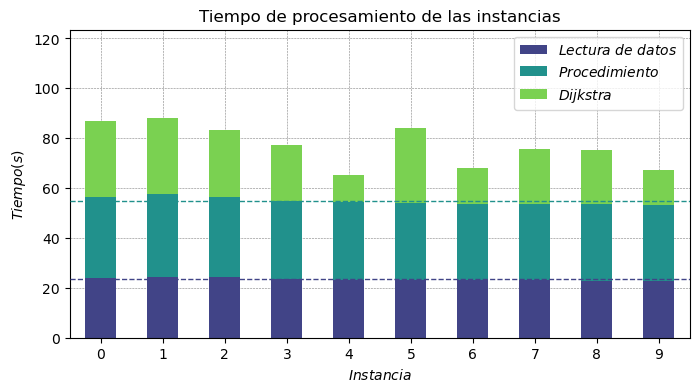

In [18]:

# Datos para cada parte de la barra
parte1 = promedio_info
parte2 = promedio_procesos
parte3 = promedio_cuda

prom_p1 = np.mean(parte1)
prom_p2 = np.mean(np.array(parte2)+np.array(parte1))
tareas = [str(i) for i in range(num_instancias)]

# Posiciones en el eje x para cada grupo de barras
x = range(len(tareas))

fig, ax = plt.subplots(figsize=(8, 4))
# Crear las barras con múltiples secciones
ax.bar(x, parte1, width=0.5, label='$Lectura\ de\ datos$', color=cmap(0.2),zorder=2)
ax.bar(x, parte2, width=0.5, label='$Procedimiento$', color=cmap(0.5), bottom=parte1, zorder=2)
ax.bar(x, parte3, width=0.5, label='$Dijkstra$', color=cmap(0.8), bottom=[parte1[i] + parte2[i] for i in range(len(parte1))], zorder=2)

ax.plot([-.5,9.5],[prom_p1, prom_p1], color=cmap(0.2), linestyle='--', linewidth=1, zorder=3)
ax.plot([-.5,9.5],[prom_p2, prom_p2], color=cmap(0.5), linestyle='--', linewidth=1, zorder=3)
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, 1.4*np.max(np.array(promedio_total))])


# Etiquetas y título
ax.set_xlabel('$Instancia$')
ax.set_ylabel('$Tiempo (s)$')
ax.set_title('Tiempo de procesamiento de las instancias')
ax.set_xticks(x, tareas)
ax.legend(columnspacing=1, loc='upper right')
ax.grid(True,zorder=0, color='gray', linestyle='--', linewidth=0.4)
ax.set_ylim([0, 1.4*np.max(np.array(promedio_total))])

fig.savefig('/home/cic/Tesis/Figuras/Results/tiemposIntegracion.png', dpi=300)

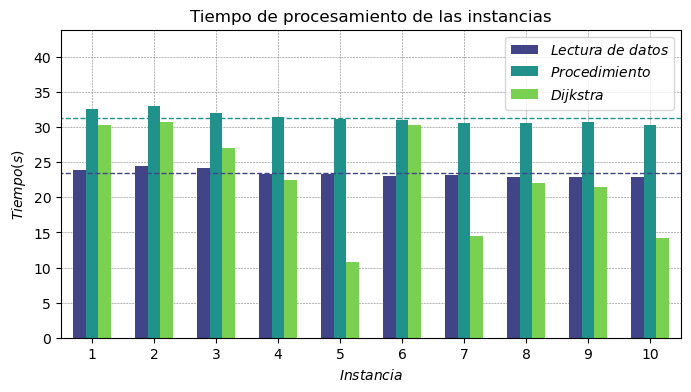

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))

# Coordenadas x para las barras
ind = np.arange(num_instancias)  # Posiciones en el eje x

# Ancho de las barras
ancho_barra = 1
esp = 0.15 # Espacio entre barras

# Dibujar las barras
rects1 = ax.bar(2*ind + ind*3 - 0.5, promedio_info, ancho_barra, label='$Lectura\ de\ datos$', color=cmap(0.2), zorder = 2)
rects2 = ax.bar(2*ind + ind*3 + 1 - 0.5, promedio_procesos, ancho_barra, label='$Procedimiento$', color=cmap(0.5), zorder = 2)
rects3 = ax.bar(2*ind + ind*3 + 2 - 0.5, promedio_cuda, ancho_barra, label='$Dijkstra$', color=cmap(0.8), zorder = 2)

ax.plot([-10,100],[np.mean(promedio_info), np.mean(promedio_info)], color=cmap(0.2), linestyle='--', linewidth=1, zorder=2)
ax.plot([-10,100],[np.mean(promedio_procesos), np.mean(promedio_procesos)], color=cmap(0.5), linestyle='--', linewidth=1, zorder=2)

# Configuración de ejes y etiquetas
ax.set_xlabel('$Instancia$')
ax.set_ylabel('$Tiempo (s)$')
ax.set_title('Tiempo de procesamiento de las instancias')
ax.set_xticks([i*2 + 3 * i + 0.5 for i in range(len(tiempos_nx))])
ax.set_xticklabels([f'{i+1}' for i in range(len(tiempos_nx))])
ax.set_xlim([-2, 2*(num_instancias-1) + 3*(num_instancias-1) +3])
ax.set_ylim([0, 1.4*np.max([np.mean(promedio_info), np.mean(promedio_procesos), np.mean(promedio_cuda)])])

# Leyenda para identificar los modelos
ax.legend()
ax.grid(True,zorder=0, color='gray', linestyle='--', linewidth=0.4)
# Mostrar la gráfica
fig.savefig('/home/cic/Tesis/Figuras/Results/tiemposIntegracion2.png', dpi=300)

AttributeError: 'dict' object has no attribute 'sort'